# Non Linear Probabilistic Component Analysis

There is to find the posterior parameters of the random variable Z, assuming that the distribution is normal.Computed distribution will be the hidden representation of the data.

<img src="NLPCA.png">

In [1]:
import numpy as np
import inferpy as inf
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# number of components
n_comp = 2
# size of the hidden layer in the NN
hidden_dim = 10
# dimensionality of the data
data_dim = 30

In [ ]:
from sklearn.datasets import load_digits
data = load_digits()

x_train = data.data
data.data.shape

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

x_train = data.data
data.data.shape

(569, 30)

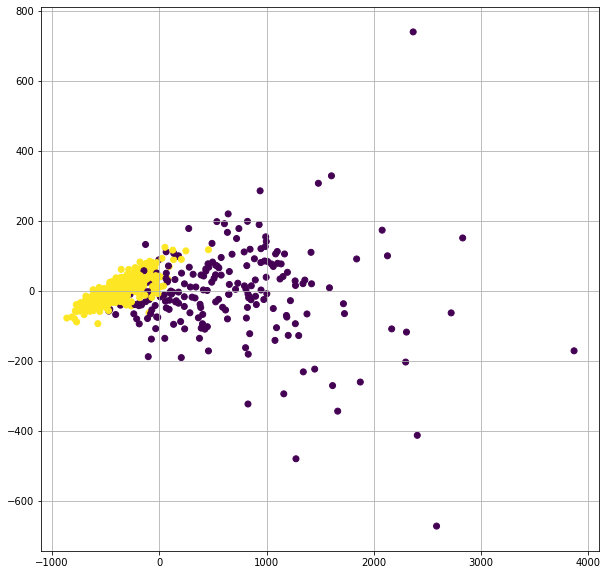

In [4]:
from sklearn.decomposition import PCA

#reduce down to 50 dim
pca = PCA(n_components=n_comp)
data_pca_tsne = pca.fit_transform(x_train)

#further reduce to 2 dim using t-SNE
# data_pca_tsne = TSNE(n_components=2).fit_transform(data_pca)

plt.figure(figsize=(10, 10))
plt.scatter(data_pca_tsne[:, 0], data_pca_tsne[:, 1], c=data.target)
plt.grid()

In [5]:
def decoder(z, hidden_dim, data_dim):
    h = tf.layers.dense(inputs=z, units=hidden_dim, activation=tf.nn.relu)
    return tf.layers.dense(inputs=h, units=2*data_dim)


# model scheme
@inf.probmodel
def nlpca(n_comp, hidden_dim, data_dim, decoder):

    with inf.datamodel() as m:
        z = inf.Normal(loc=tf.ones([n_comp]) * 0.5, scale=1.0, name="z")# shape = [N, n_comp]
        output = decoder(z, hidden_dim, data_dim)
        x_loc = output[:, :data_dim]
        x_scale = tf.nn.softmax(output[:,data_dim:])
        x = inf.Normal(x_loc, x_scale, name="x")# shape = [N,d]

# inference
@inf.probmodel
def qmodel(k):
    with inf.datamodel():
        qz_loc = inf.Parameter(initial_value=tf.ones([k]) * 0.5, name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(initial_value=tf.ones([k]), name="qz_scale"))

        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

The "with" statement open context which is scheme for probabilistic model.<br>
"inf.Normal(.." declare random variable with Normal distribution. In this situation "z" represent latent variable<br>
loc - mean, scale - std(sigma)<br>


In [6]:
# create an instance of the model
model = nlpca(n_comp, hidden_dim, data_dim, decoder)

# set the inference algorithm
VI = inf.inference.VI(qmodel(n_comp), epochs=40000)

# learn the parameters
model.fit({"x": x_train}, VI)

W0814 05:12:21.854038 140040990328640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/models/prob_model.py:62: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0814 05:12:21.883782 140040990328640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 05:12:21.889781 140040990328640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/models/random_variable.py:430: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W0814 05:12:21.913013 140040990328640 deprecation.py:323] From <ipython-input-5-75f8798a86f6>:2: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0814 05:12:21.916936 14004099032864


 0 epochs	 471674716160.0....................
 200 epochs	 76610551808.0....................
 400 epochs	 24481654784.0....................
 600 epochs	 14518222848.0....................
 800 epochs	 10072613888.0....................
 1000 epochs	 8415585280.0....................
 1200 epochs	 7411925504.0....................
 1400 epochs	 6864769024.0....................
 1600 epochs	 6284713984.0....................
 1800 epochs	 6017392640.0....................
 2000 epochs	 5655013888.0....................
 2200 epochs	 5435541504.0....................
 2400 epochs	 5223645184.0....................
 2600 epochs	 5079836672.0....................
 2800 epochs	 4931388416.0....................
 3000 epochs	 4845821952.0....................
 3200 epochs	 4740819456.0....................
 3400 epochs	 4717892608.0....................
 3600 epochs	 4599984128.0....................
 3800 epochs	 4483097600.0....................
 4000 epochs	 4444339200.0....................
 4200 epochs	

In [7]:
#extract the hidden representation
hidden_encoding = model.posterior("z")
data_nlpca_tsne = hidden_encoding.sample()

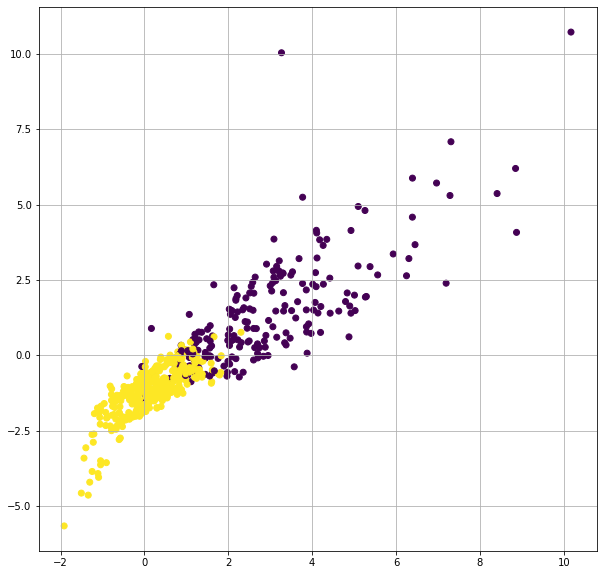

In [8]:
#further reduce to 2 dim using t-SNE
# data_nlpca_tsne = TSNE(n_components=2).fit_transform(red_data)

plt.figure(figsize=(10,10))
plt.scatter(data_nlpca_tsne[:, 0], data_nlpca_tsne[:, 1], c=data.target)
plt.grid()

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


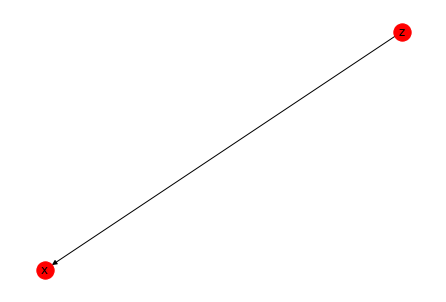

In [28]:
model.plot_graph()